

- Автор: Гущина Вера
- Дата: 21 августа 2025

## Цели и задачи проекта

<font color='#777778'> Необходимо провести предобрабоку даных и провкрить гипотезу, что "Среднее время активности пользователей в Санкт-Петербурге больше, и это различие статистически значимо".</font>

## Описание данных

<font color='#777778'>Для анализа представлен файл yandex_knigi_data.csv, содержащий данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности.</font>


## Содержимое проекта

<font color='#777778'> 

    
- Загрузка данных.
    
- Проверка наличия дубликатов в идентификаторах пользователей.
    
- Сравнение размеров групп, их статистики и распределение.
    
- Проверка гипотезы.
    
- Выводы и рекомендации.</font>

---

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from math import ceil
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize
from statsmodels.stats.proportion import proportions_ztest

## 1. Загрузка данных и знакомство с ними

Загрузите данные пользователей из Москвы и Санкт-Петербурга c их активностью (суммой часов чтения и прослушивания) из файла `/datasets/yandex_knigi_data.csv`.

In [2]:
# загрузим данные пользователей из Москвы и Санкт-Петербурга c суммой часов их активности из файла yandex_knigi_data.csv
df_knigi=pd.read_csv('/datasets/yandex_knigi_data.csv')

In [3]:
# выгрузим информацию о датафрейме
display(df_knigi.head(5))
df_knigi.info()

,Unnamed: 0,city,puid,hours
0,0,Москва,9668,26.167776
1,1,Москва,16598,82.111217
2,2,Москва,80401,4.656906
3,3,Москва,140205,1.840556
4,4,Москва,248755,151.326434


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  8784 non-null   int64  
 1   city        8784 non-null   object 
 2   puid        8784 non-null   int64  
 3   hours       8784 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 274.6+ KB


В данных отсутствуют пропуски. Типы данных определены корректно.

In [4]:
# удалим столбец без названия
del df_knigi['Unnamed: 0']

In [5]:
# проверим данные на наличие полных дубликатов
full_duplicates = df_knigi.duplicated()
num_full_duplicates = full_duplicates.sum()
print(f'Количество явных дубликатов: {num_full_duplicates}')

Количество явных дубликатов: 0


In [6]:
# проверим данные на наличие дубликатов по puid
duplicates = df_knigi['puid'].duplicated()
num_duplicates = duplicates.sum()
percent = round(num_duplicates/len(df_knigi)*100,2)
print(f'Количество дубликатов по puid: {num_duplicates}, что составляет {percent}%')

Количество дубликатов по puid: 244, что составляет 2.78%


In [7]:
# удалим дубликаты
df_unique=df_knigi.drop_duplicates(subset=['puid'],keep='first')

In [8]:
# проверим пересечение пользователей в группах по идентификатору
a = df_unique[df_unique['city'] == 'Москва']['puid']
b = df_unique[df_unique['city'] == 'Санкт-Петербург']['puid']

intersection = list(set(a) & set(b))
count = len(set(a) & set(b))
print(intersection) 
print (f'Количество пользователей, включенных в обе группы: {count}')

[]
Количество пользователей, включенных в обе группы: 0


In [9]:
# посчитаем сумму уникальных пользователей по каждой тестовой группе
group_spb=df_unique[df_unique['city']=='Санкт-Петербург']['puid'].nunique()
group_moscow=df_unique[df_unique['city']=='Москва']['puid'].nunique()

# расчитаем процентную разницу
p=(group_spb-group_moscow)/group_spb*100

print (f'Количество пользователей в Санкт-Петербурге: {group_spb}')
print (f'Количество пользователей в Москве: {group_moscow}')
print(f"Процентная разница в количестве пользователей в Санкт-Петербурге и Москве: {round(float(p),2)}%")


Количество пользователей в Санкт-Петербурге: 2306
Количество пользователей в Москве: 6234
Процентная разница в количестве пользователей в Санкт-Петербурге и Москве: -170.34%


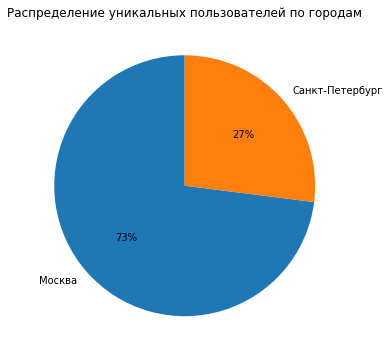

In [10]:
# построим круговую диаграмму для визуализауции соотношения количества пользователей по городам
df_city_group = (
    df_unique
    .groupby(['city'])
    .agg({
        'puid': 'nunique',
    })
    .reset_index()
)

plt.figure(figsize=(6,6))
plt.pie(
    df_city_group['puid'], 
    labels=df_city_group['city'], 
    autopct='%1.0f%%', 
    startangle=90
)
plt.title('Распределение уникальных пользователей по городам')
plt.show()

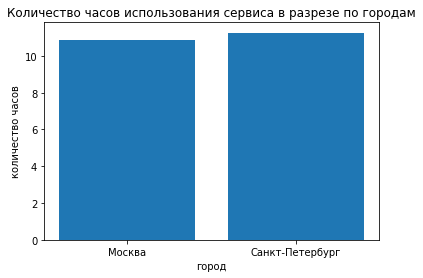

,city,hours
0,Москва,10.881092
1,Санкт-Петербург,11.264433


In [11]:
# посчитаем среднее количество часов пользования сервисом и построим гистограмму
df_city_group_hours = (
    df_unique
    .groupby(['city'])
    .agg({
        'hours': 'mean',
    })
    .reset_index()
)

x = df_city_group_hours['city']
y = df_city_group_hours['hours']
             
plt.bar(x, y)
plt.xlabel('город')
plt.ylabel('количество часов')
plt.title('Количество часов использования сервиса в разрезе по городам')
plt.show()

display(df_city_group_hours)

Среднее количество часов пользования серфисом в Санкт-Петербурге выше, чем в Москве.

По итогу анализа данных установлено, что группы для проведения А/В тестирования распределены неравномено (27% Санкт-Петербург, 73% Москва), при этом среднее количество часов использования сервиса в Санкт-Петербурге выше, чем в Москве (11.26 против 10.88). Расчет данной метрики необходим для проверки гипотезы теста. Учитывая, что численная разница в группах большая (около 170%) для проверки выберем тест Уэлча, позволяющий проводить стат.тест при различающихся выборках.

## 2. Проверка гипотезы в Python

Гипотеза звучит так: пользователи из Санкт-Петербурга проводят в среднем больше времени за чтением и прослушиванием книг в приложении, чем пользователи из Москвы. Попробуйте статистически это доказать, используя одностороннюю проверку гипотезы с двумя выборками:

- Нулевая гипотеза H₀: Средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается.

- Альтернативная гипотеза H₁: Средняя активность пользователей в Санкт-Петербурге больше, и это различие статистически значимо.

In [12]:
# разделим выборки по городам
spb = df_unique[df_unique['city'] == 'Санкт-Петербург']['hours']
moscow = df_unique[df_unique['city'] == 'Москва']['hours']

# используем односторонний t-тест Уэлча, так как размеры выборок различные: 

t_stat, p_value_welch_ttest= ttest_ind(spb, moscow, 
                                      equal_var=False, 
                                      alternative= 'greater')

# Уровень значимости
alpha = 0.05

if p_value_welch_ttest>alpha:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Интерпретация: недостаточно оснований отвергнуть H0. Нет статистически значимого превосходства СПб над Москвой')
else:
    print(f'p-value теста Уэлча ={round(p_value_welch_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Интерпретация: Среднее время активности в СПб статистически больше, чем в Москве')


p-value теста Уэлча =0.34
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны
Интерпретация: недостаточно оснований отвергнуть H0. Нет статистически значимого превосходства СПб над Москвой


## 3. Аналитическая записка
По результатам анализа данных подготовьте аналитическую записку, в которой опишете:

- Выбранный тип t-теста и уровень статистической значимости.

- Результат теста, или p-value.

- Вывод на основе полученного p-value, то есть интерпретацию результатов.

- Одну или две возможные причины, объясняющие полученные результаты.



------

Для проверки гипотезы в связи с тем, что размеры выборок значительно отличаются (Москва - 73%, Санкт-Петербург 27%) был выбран тест Уэлча. Уровень статистичекой значимости был установлен 0.05, как стандартный для таких исследований.
p-value по результатам теста 0.34, что не позволило нам отвергнуть нулевую гипотезу, следовательно, средняя активность пользователей в часах в двух группах (Москва и Санкт-Петербург) не различается. 

Учитывая, что у жителей этих городов схожий образ жизни и бытовые привычки, возможной причиной, по которой не удалось опровергнуть гипотезу является недостаточность выборок.